### application 데이터 세트에 다양한 feature engineering 수행. 
* application_train(test) 주요 feature값들의 분포도등의 EDA 수행. 
* application_train(test) 주요 feature 들의 추가적인 가공을 통한 feature engineering 수행. 

#### 라이브러리와 app 데이터 세트 로딩

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import random

from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

In [2]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

In [3]:
app_train.isnull().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [4]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [5]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


#### 연속형 숫자 feature들에 대해서 TARGET값이 각각 0과 1일때의 Histogram 시각화
* violinplot과 distplot으로 숫자형 feature들에 대해 TARGET값 별 분포도 비교 시각화

In [6]:
num_columns = app_train.dtypes[app_train.dtypes != 'object']
print(num_columns)

SK_ID_CURR                        int64
TARGET                            int64
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64
FLAG_CONT_MOBILE                  int64
FLAG_PHONE                        int64
FLAG_EMAIL                        int64
CNT_FAM_MEMBERS                 float64
REGION_RATING_CLIENT              int64
REGION_RATING_CLIENT_W_CITY       int64
HOUR_APPR_PROCESS_START           int64
REG_REGION_NOT_LIVE_REGION        int64
REG_REGION_NOT_WORK_REGION        int64


In [7]:
def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        sns.violinplot(x='TARGET', y=column, data=df, ax=axs[0][0] )
        sns.distplot(df[cond_0][column], ax=axs[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='red')

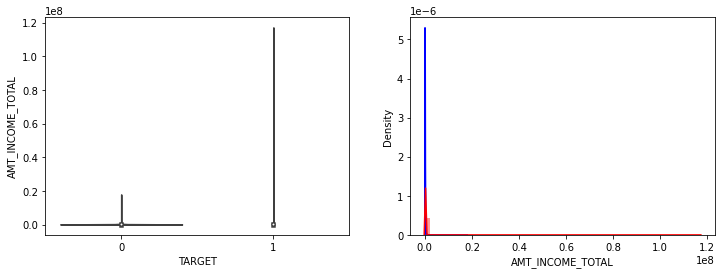

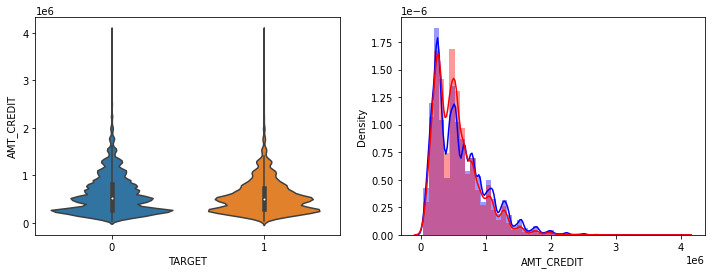

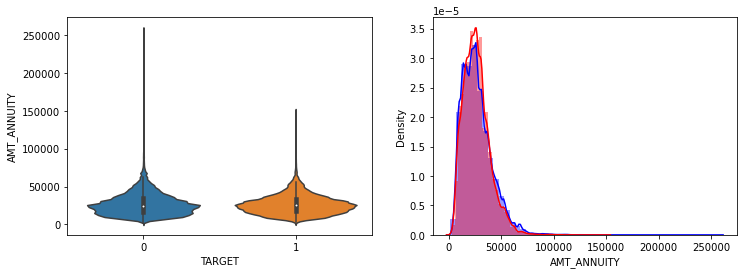

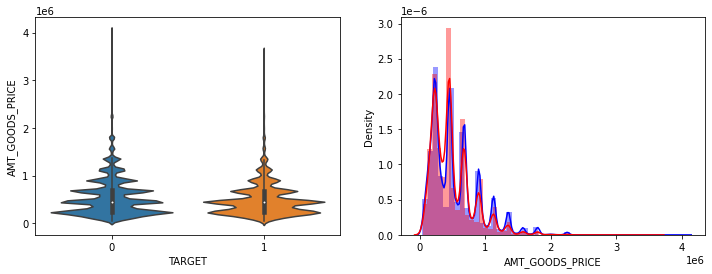

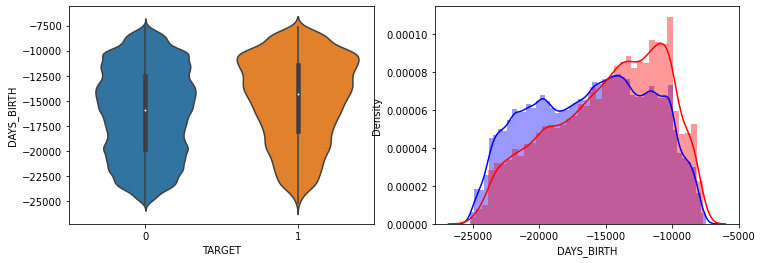

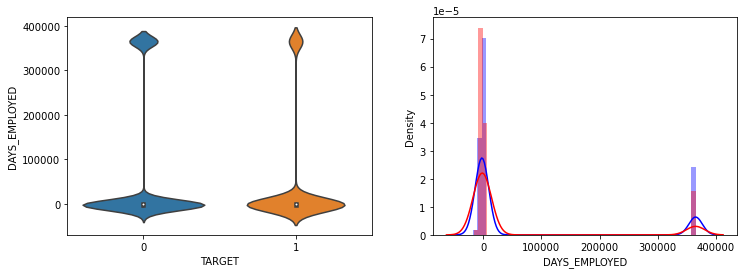

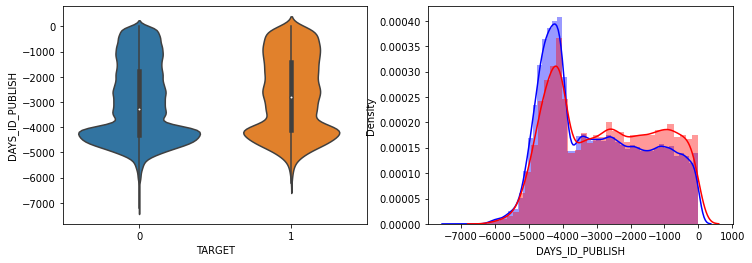

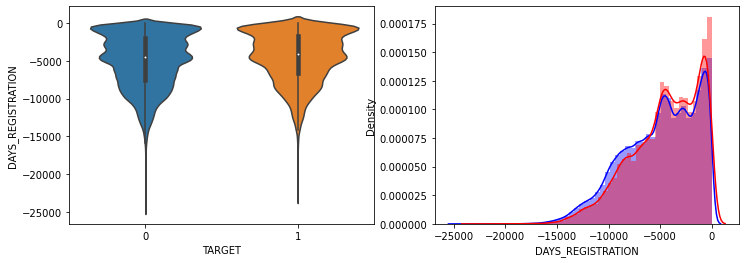

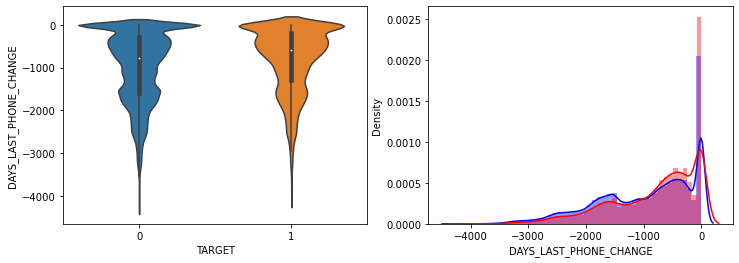

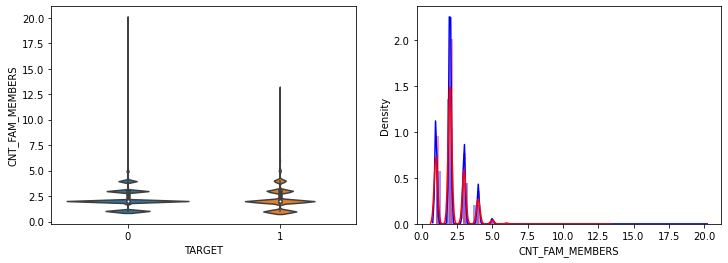

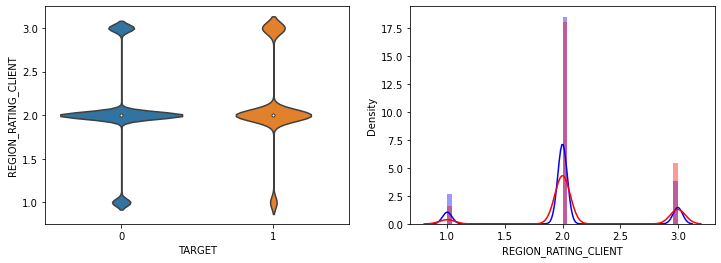

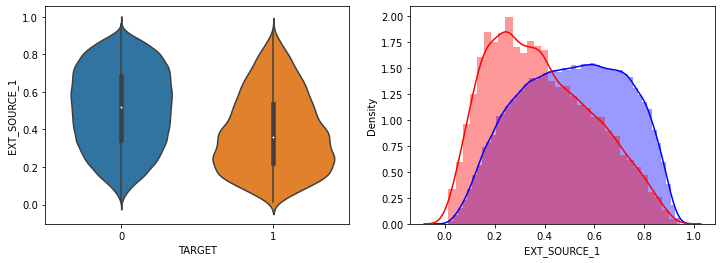

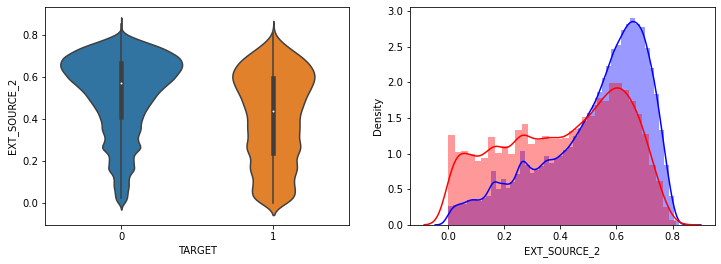

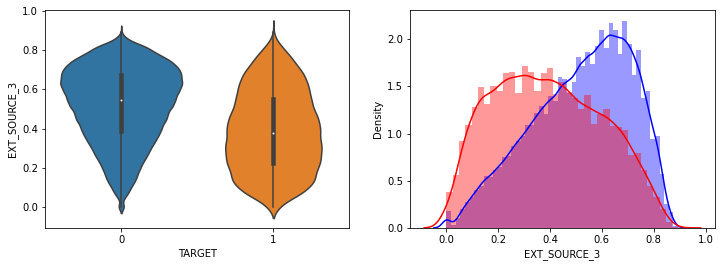

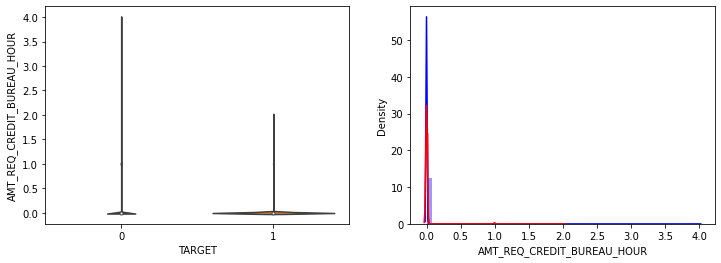

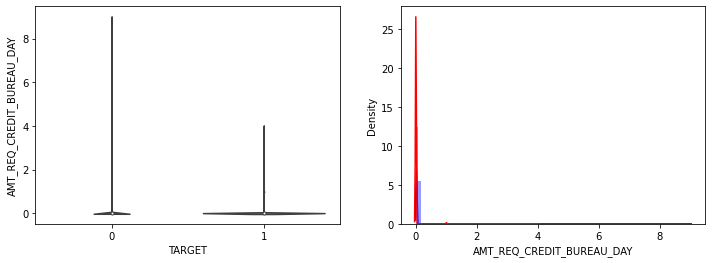

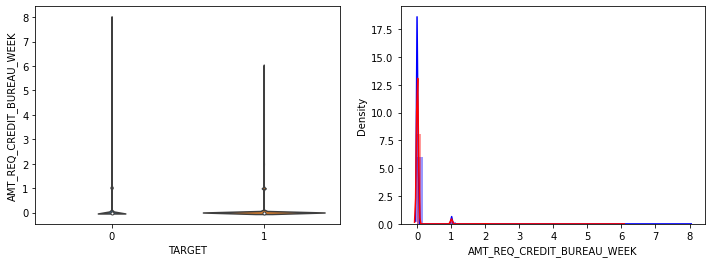

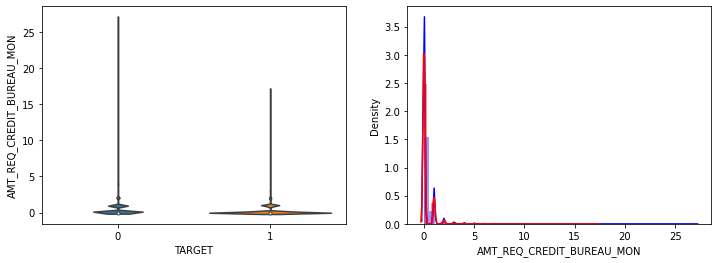

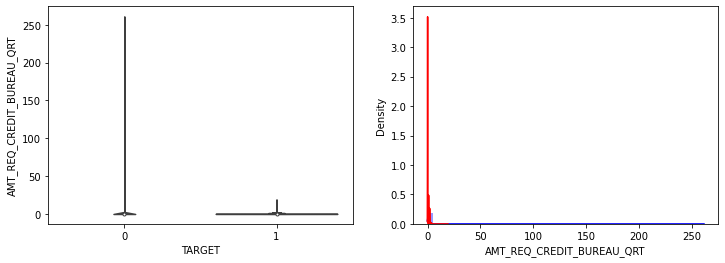

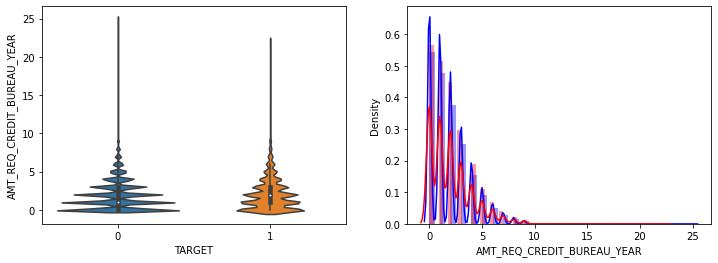

In [8]:
columns = ['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
           'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'EXT_SOURCE_1', 
           'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
           'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

show_hist_by_target(app_train, columns)

* AMT_INCOME_TOTAL, AMT_CREDIT 은 크게 차이가 없음. 
* AMT_ANNUITY는 TARGET=1시 상대적으로 작은 숫자대의 값이 조금 많음. 
* AMT_GOOD_PRICE는 크게 차이가 없음. 
* DAYS_BIRTH는 TARGET=1시 적은 연령대의 숫자값이 상대적으로 많음. 
* DAYS_EMPLOYED는 TARGET=1시 작은 값들이 조금 더 많음. 
* DAYS_ID_PUBLISH, DAYS_REGISTRATION  는 TARGET=1시 최근 값들이 조금 더 많음. 
* DAYS_LAST_PHONE_CHANGE는 큰 차이 없음. 
* CNT_FAM_MEMBERS는 차이가 없음. outlier 때문에 histogram에 차이가 있어 보임. 
* REGION_RATING_CLIENT는 큰 차이 없음 
* EXT_SOURCE_1,EXT_SOURCE_2, EXT_SOURCE_3 모두 조금씩 차이가 있음.  
* 나머지 컬럼모두 큰 차이가 없음. 
* 전반적으로 연령대가 낮은(직장 경력이 적은), 소액 대출에서 상대적으로 연체 비중이 높음.  

#### seaborn의 countplot() 또는 catplot()을 이용하여 category 피처(object 컬럼)을 TARGET 유형에 따라 Count 비교

In [9]:
object_columns = app_train.dtypes[app_train.dtypes=='object'].index.tolist()
object_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

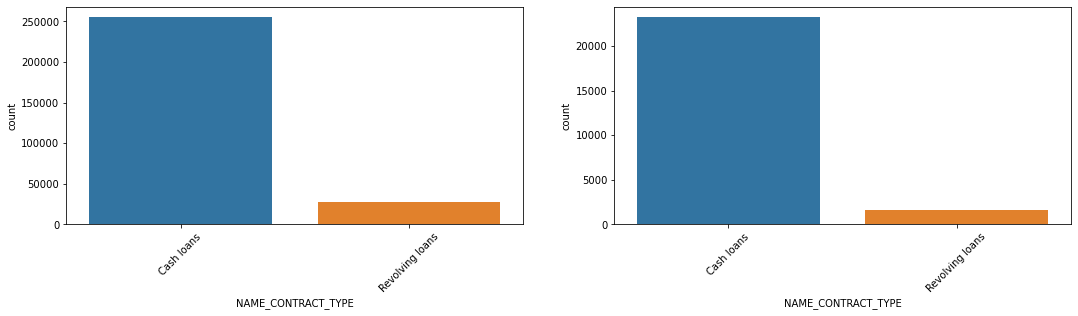

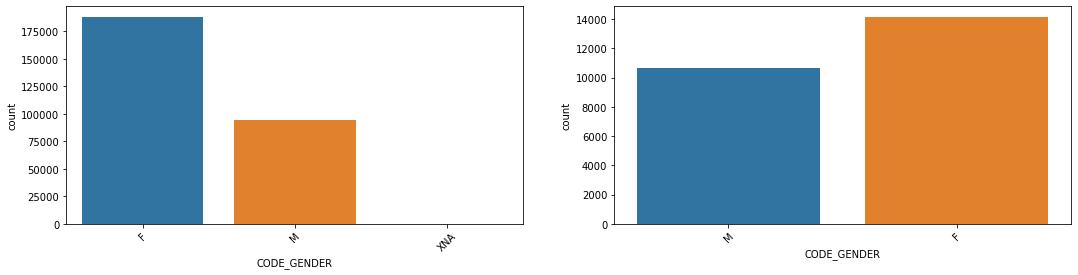

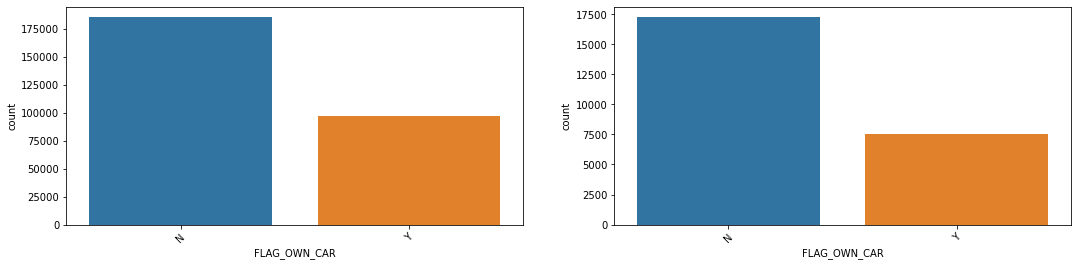

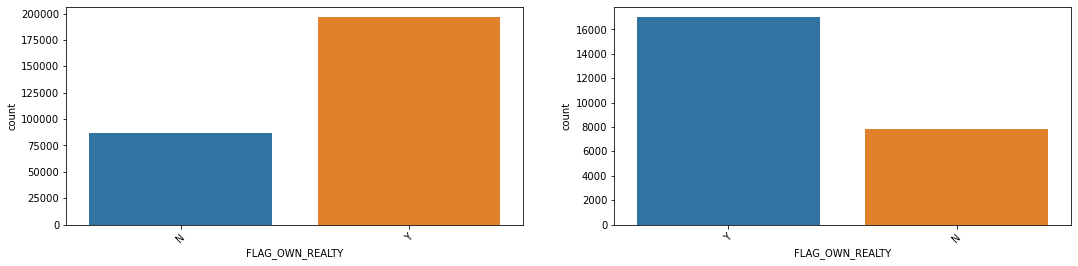

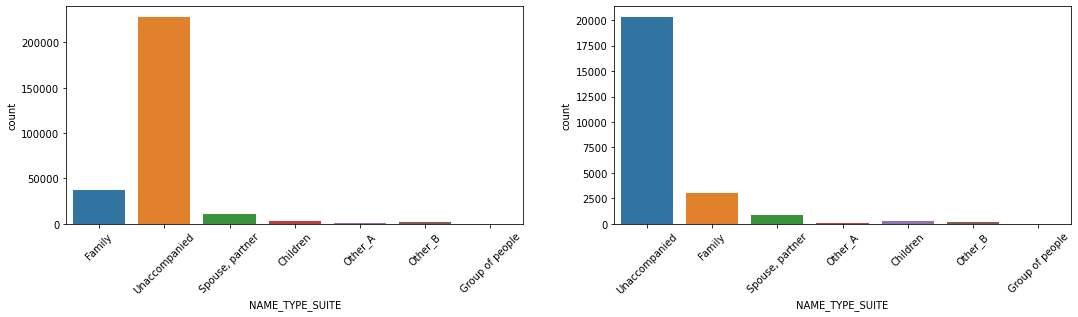

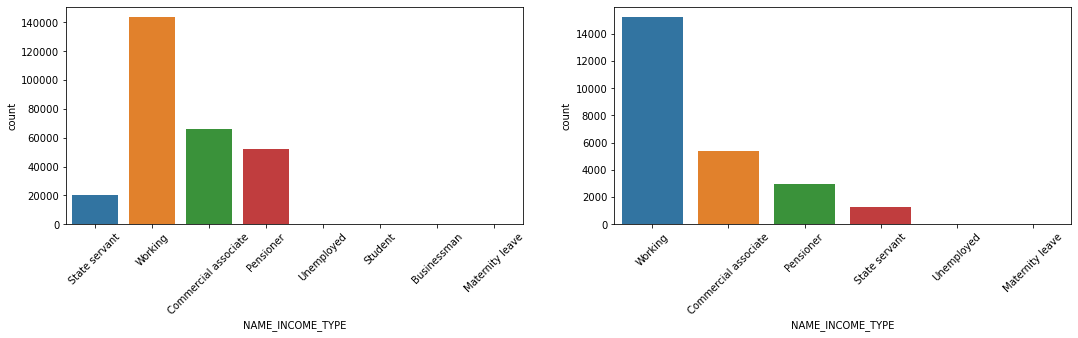

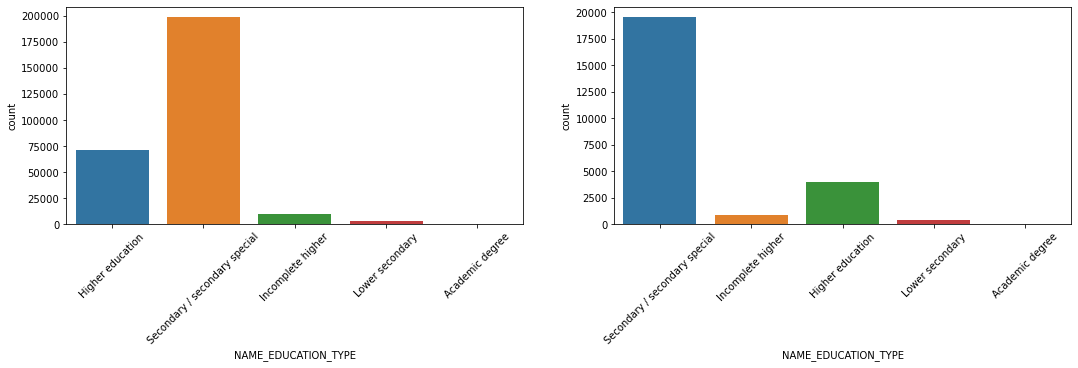

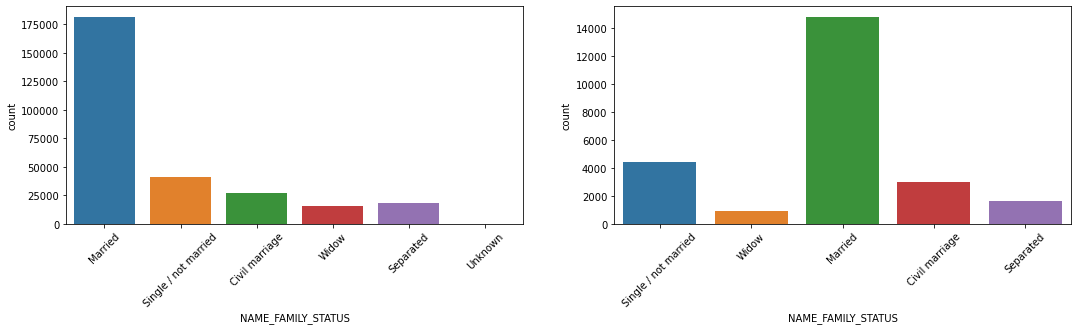

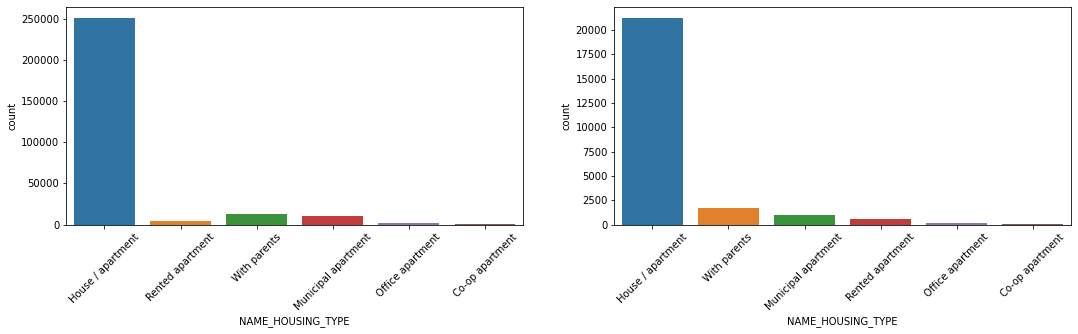

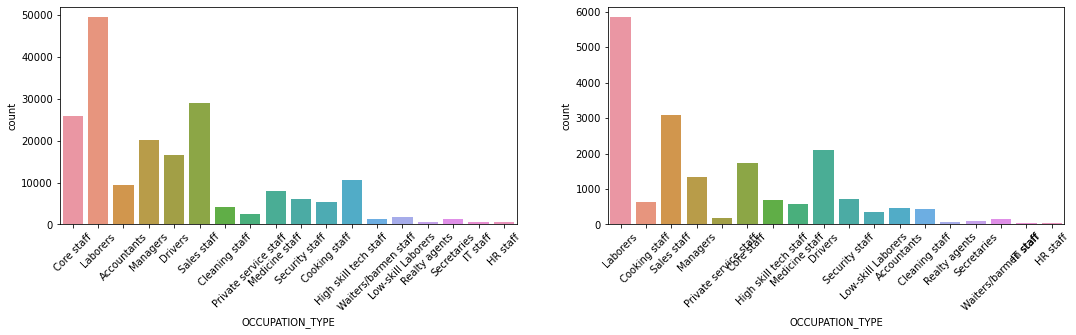

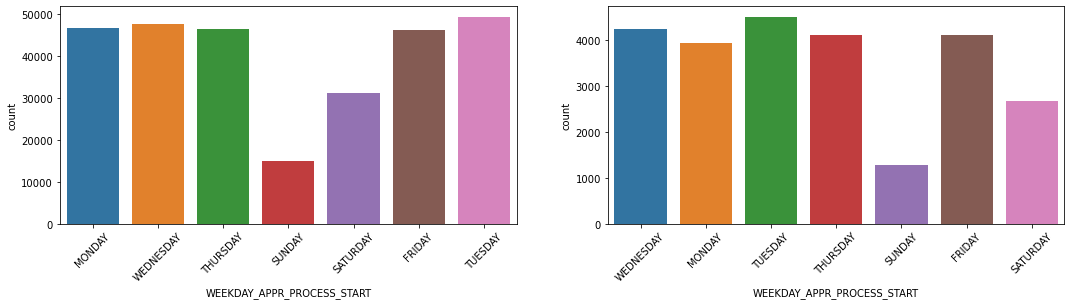

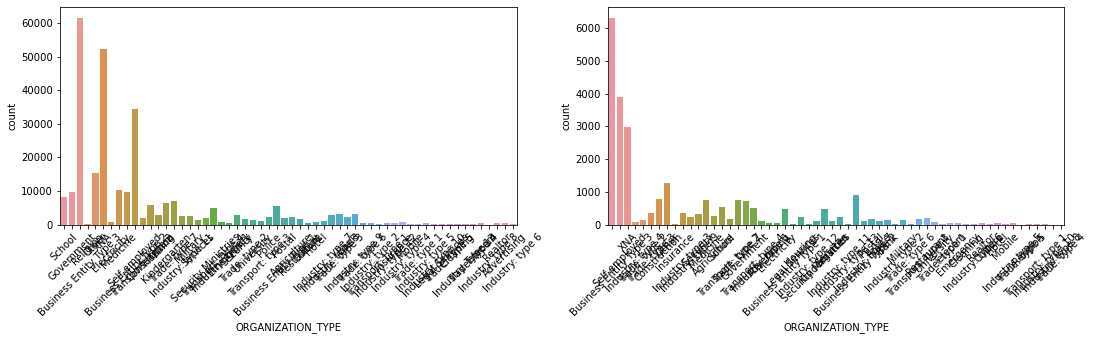

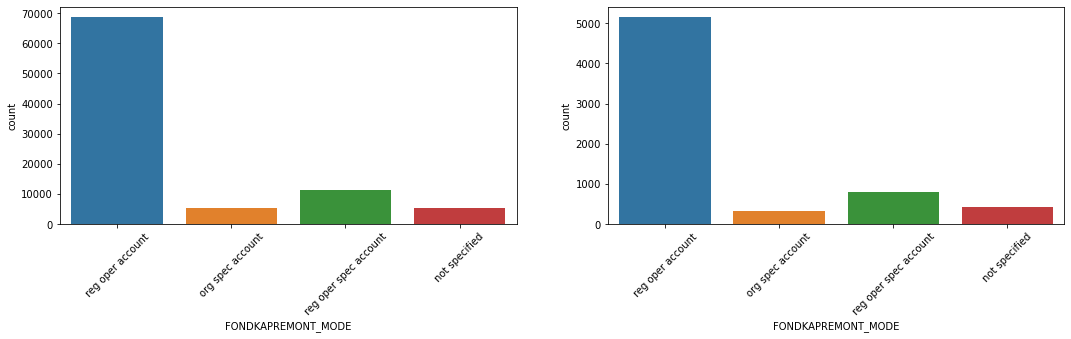

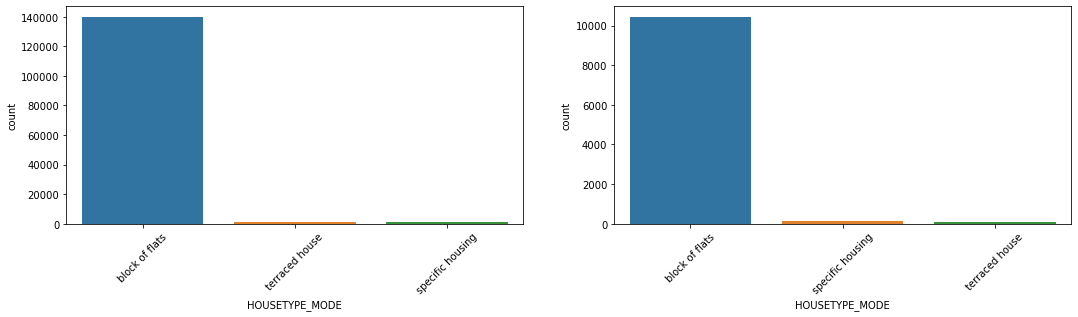

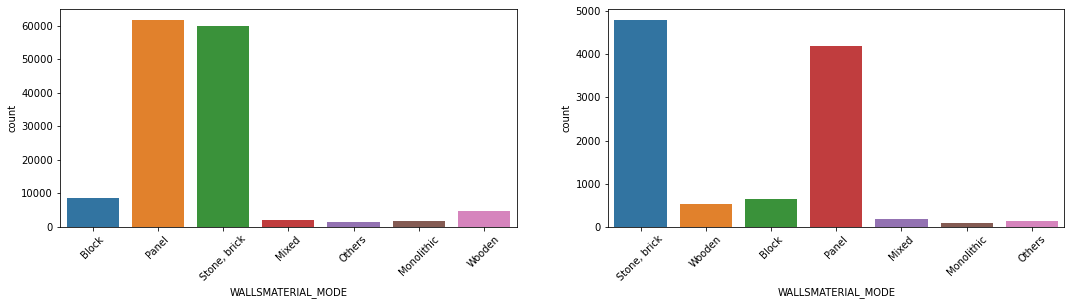

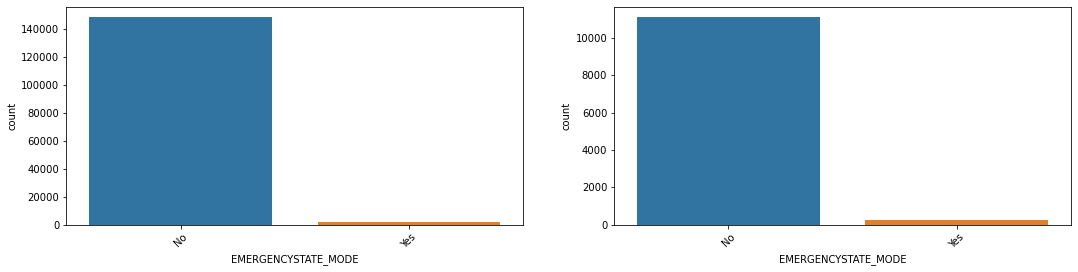

In [10]:
def show_count_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 4), squeeze=False)
        # countplot을 이용하여 category값의 histogram 표현
        chart0 = sns.countplot(df[cond_0][column], ax=axs[0][0])
        # x축의 tick label들이 값 유형이 많으므로 45도로 회전하여 표현
        chart0.set_xticklabels(chart0.get_xticklabels(), rotation=45)
        chart1 = sns.countplot(df[cond_1][column], ax=axs[0][1])
        chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45)

        
show_count_by_target(app_train, object_columns)

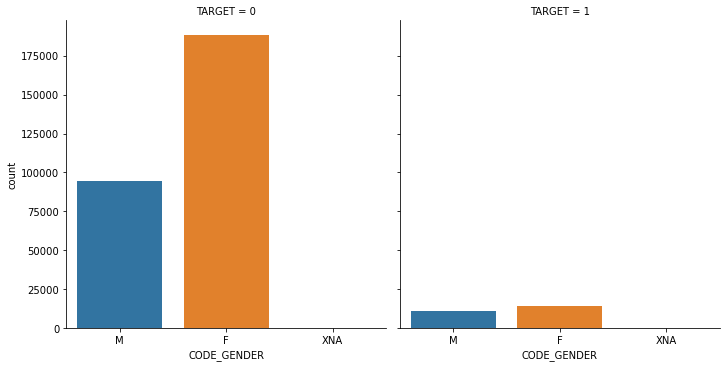

In [11]:
# catplot을 이용하여 countplot을 특정 컬럼 값 조건에 따라 여러개의 subplot을 분리하여 보여줌.  
sns.catplot(x="CODE_GENDER",col="TARGET", data=app_train, kind="count")

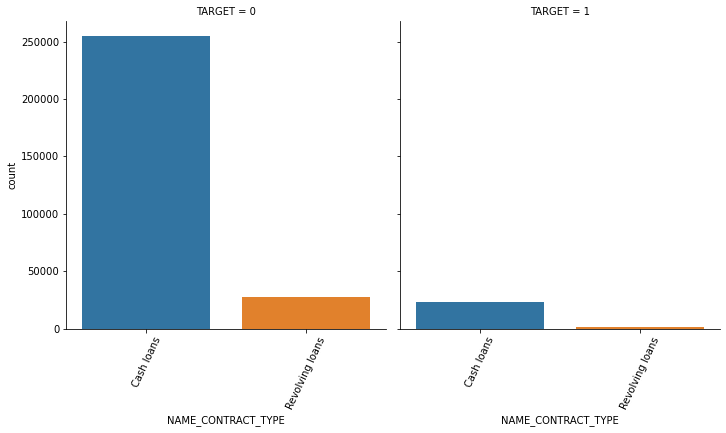

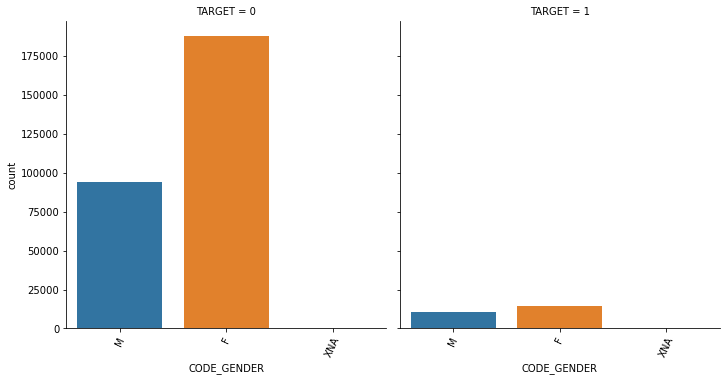

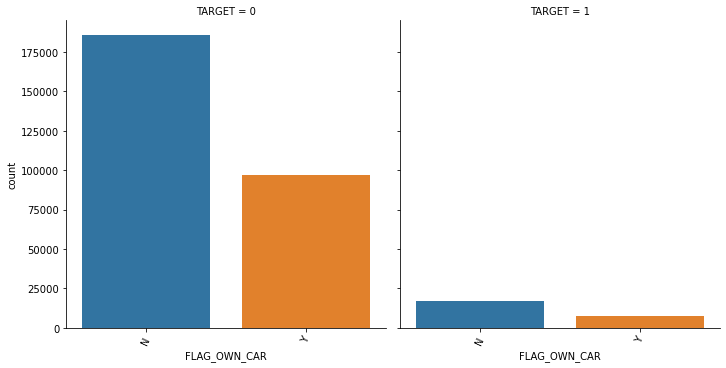

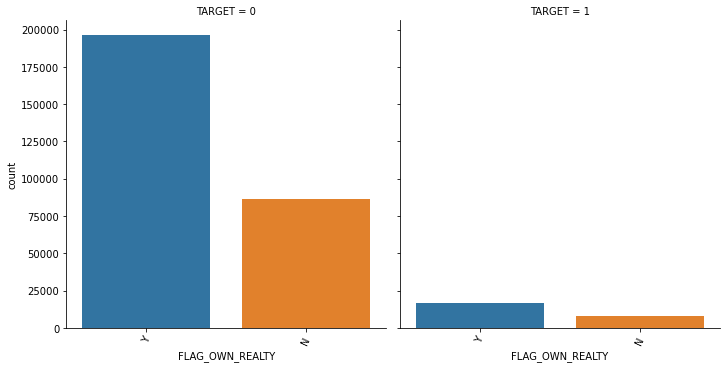

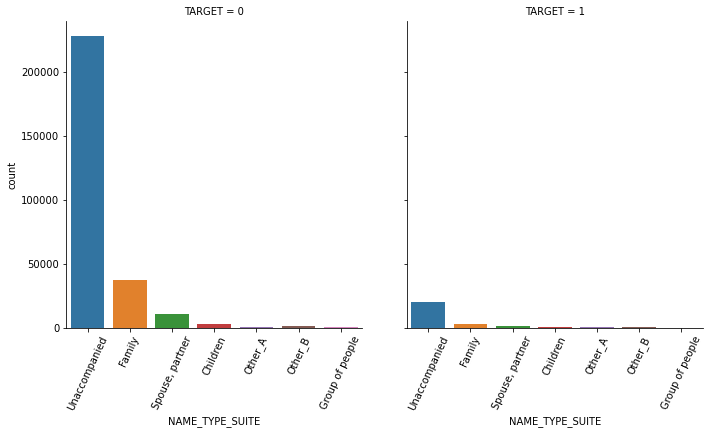

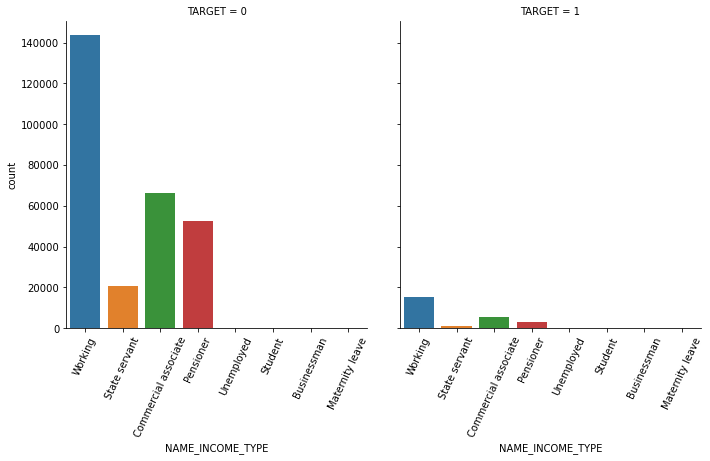

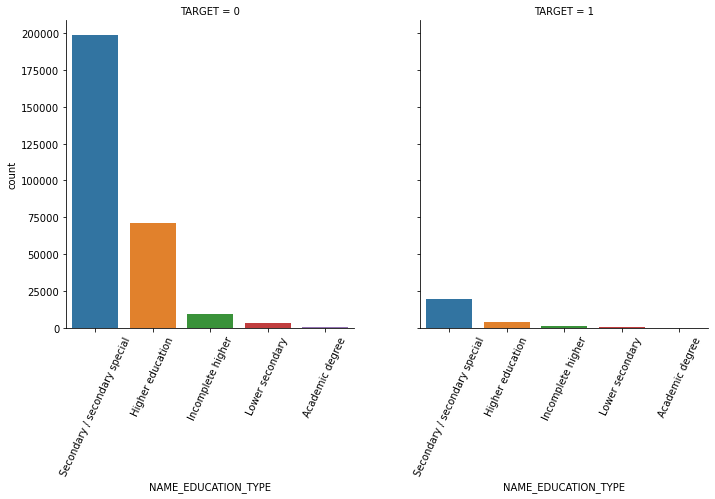

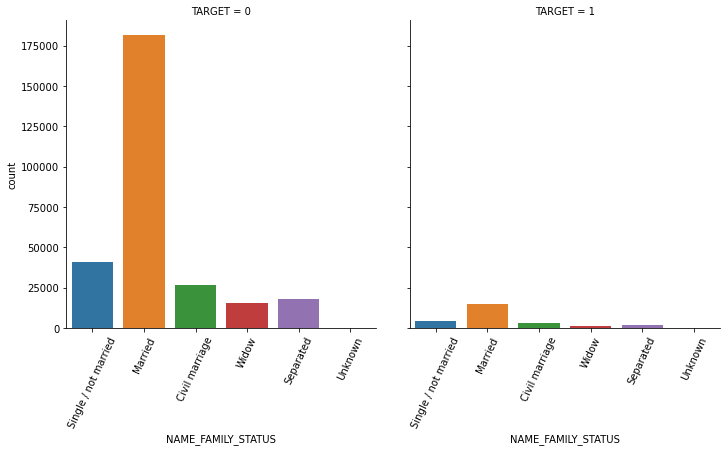

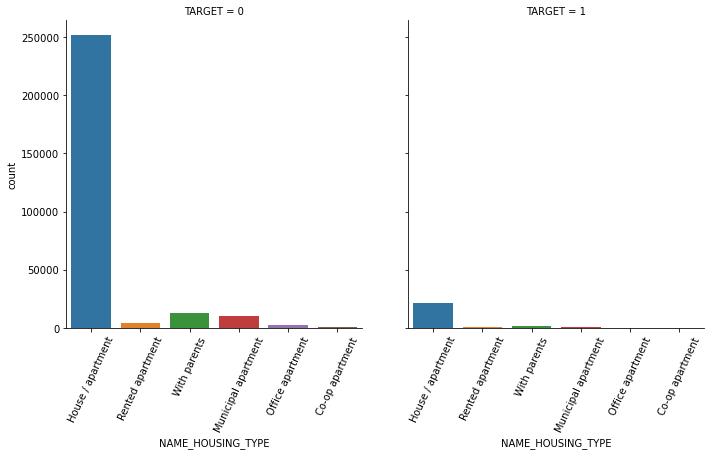

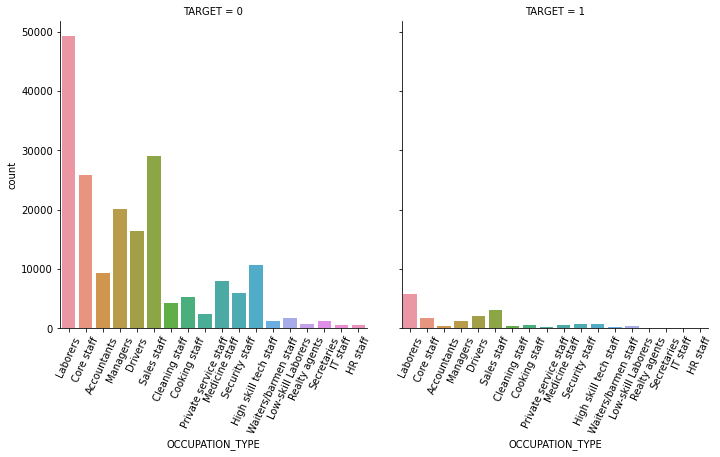

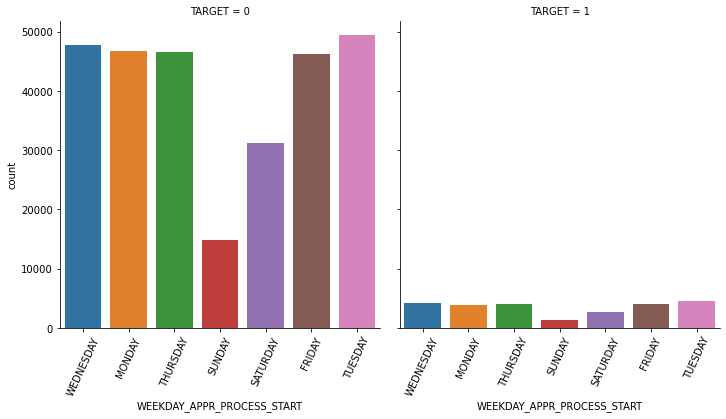

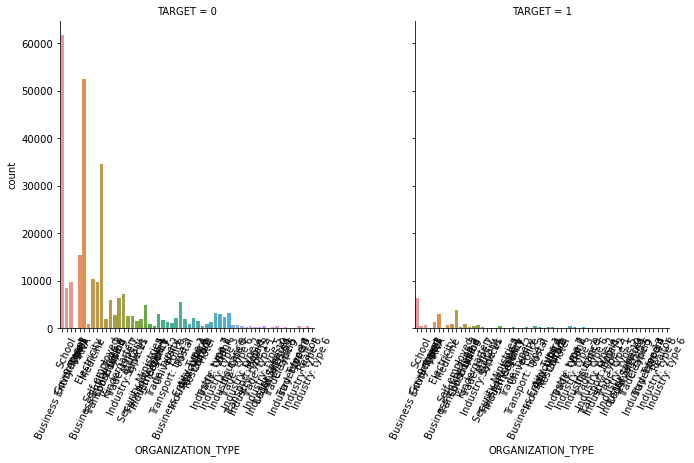

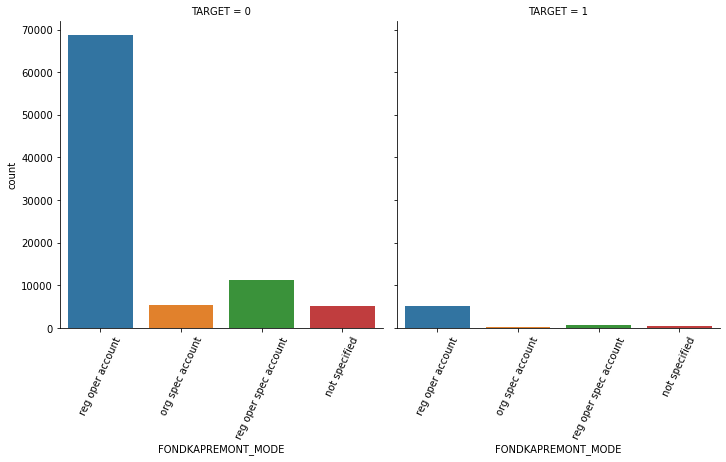

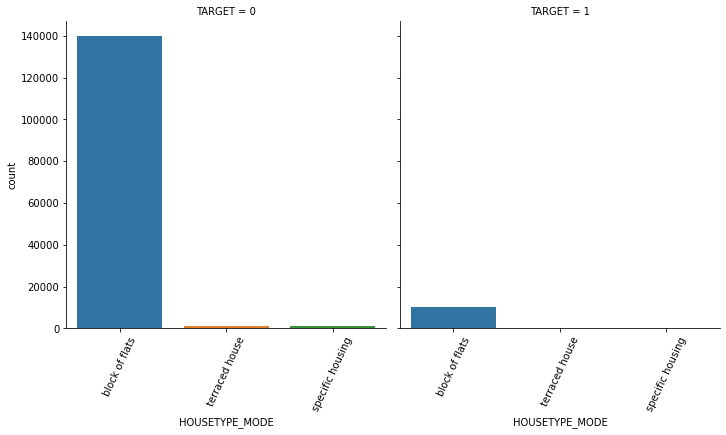

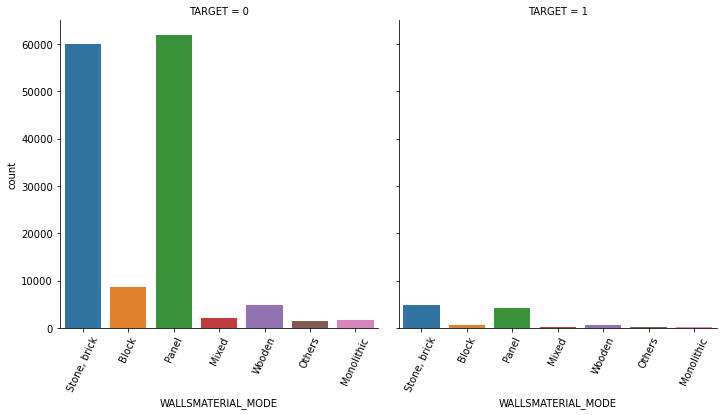

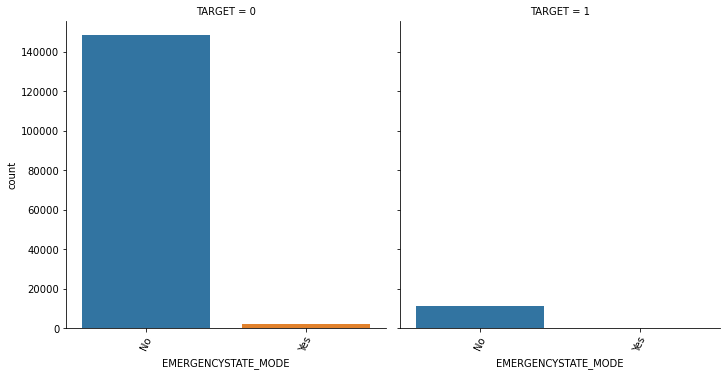

In [12]:
# catplot을 이용하여 TARGET별로 여러컬럼의 category 값 Histogram을 표현.  
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="TARGET", data=df, kind="count")
        chart.set_xticklabels(rotation=65)
        
show_category_by_target(app_train, object_columns)

#### 대출 횟수 대비 연체 비율이 남성이 여성보다 높음. 이를 value_counts()로 확인. 

In [13]:
cond_1 = (app_train['TARGET'] == 1)
cond_0 = (app_train['TARGET'] == 0)
cond_f = (app_train['CODE_GENDER'] == 'F')
cond_m = (app_train['CODE_GENDER'] == 'M')

# 전체 건수 대비 남성과 여성의 비율 확인
print(app_train['CODE_GENDER'].value_counts()/app_train.shape[0])
# TARGET=1 일 경우 남성과 여성의 비율 확인
print(app_train[cond_1]['CODE_GENDER'].value_counts()/app_train[cond_1].shape[0])
# TARGET=0 일 경우 남성과 여성의 비율 확인
print(app_train[cond_0]['CODE_GENDER'].value_counts()/app_train[cond_0].shape[0])

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64
F    0.570796
M    0.429204
Name: CODE_GENDER, dtype: float64
F      0.666032
M      0.333954
XNA    0.000014
Name: CODE_GENDER, dtype: float64


#### 주요 컬럼들의 target과의 상관도 분석

In [14]:
corr_columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
               'DAYS_EMPLOYED','DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'AMT_INCOME_TOTAL', 'TARGET']

corr = app_train[corr_columns].corr()

<AxesSubplot:>

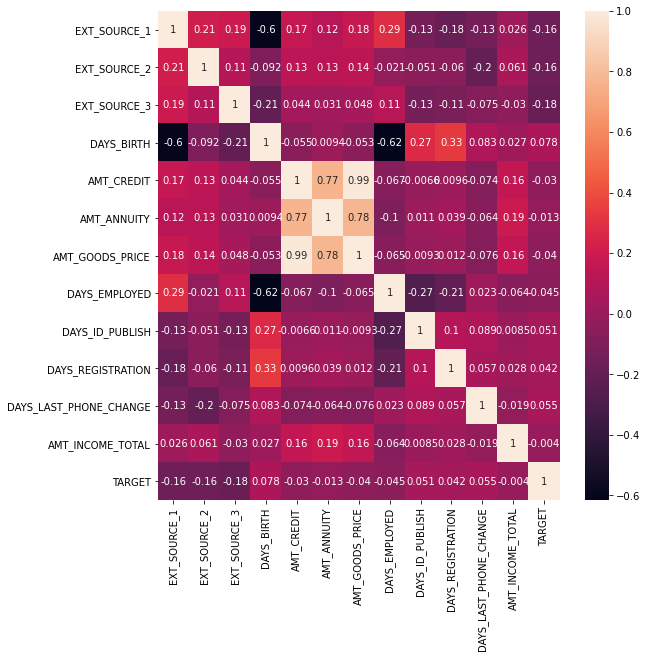

In [15]:
plt.figure(figsize=(9, 9))
sns.heatmap(corr, annot=True)

#### 이상치 데이터 확인 및 DAYS_EMPLOYED 이상치 값 변경 

In [16]:
### 365243이 매우 많음. 약 1000년치에 해당하는 날짜임.  
app_train['DAYS_EMPLOYED'].value_counts()

 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-11060         1
-10409         1
-10155         1
-11948         1
-12341         1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

In [17]:
# CODE_GENDER의 경우 XNA가 4건 정도. 많지 않으므로 그대로 유지 
app_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [18]:
# LightGBM은 NULL값을 트리 모델 생성하는데 사용할 수 있으므로 일괄적으로 Null로 변환 
app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].replace(365243, np.nan)
app_train['DAYS_EMPLOYED'].value_counts(dropna=False)

 NaN        55374
-200.0        156
-224.0        152
-230.0        151
-199.0        151
            ...  
-9681.0         1
-13421.0        1
-9703.0         1
-11283.0        1
-13497.0        1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

### 주요 Feature들에 대한 feature engineering 수행

#### EXT_SOURCE 계열값 확인, EXT_SOURCE_X 피처들의 평균/최대/최소/표준편차 확인 

In [19]:
app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].isnull().sum()

EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

In [20]:
app_train['EXT_SOURCE_1'].value_counts(dropna=False)

NaN         173378
0.546426         5
0.598469         5
0.622707         5
0.605152         5
             ...  
0.288500         1
0.807598         1
0.237983         1
0.412337         1
0.615170         1
Name: EXT_SOURCE_1, Length: 114585, dtype: int64

In [21]:
app_train['EXT_SOURCE_2'].value_counts(dropna=False)

0.285898    721
NaN         660
0.262258    417
0.265256    343
0.159679    322
           ... 
0.009063      1
0.457284      1
0.017615      1
0.371661      1
0.064909      1
Name: EXT_SOURCE_2, Length: 119832, dtype: int64

In [22]:
app_train['EXT_SOURCE_3'].value_counts(dropna=False)

NaN         60965
0.746300     1460
0.713631     1315
0.694093     1276
0.670652     1191
            ...  
0.028674        1
0.896010        1
0.858178        1
0.017506        1
0.028275        1
Name: EXT_SOURCE_3, Length: 815, dtype: int64

In [23]:
# EXT_SOURCE_X 피처들의 평균/최대/최소/표준편차 확인 
print('### mean ###\n', app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean())
print('### max ###\n',app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max())
print('### min ###\n',app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min())
print('### std ###\n',app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std())

### mean ###
 EXT_SOURCE_1    0.502130
EXT_SOURCE_2    0.514393
EXT_SOURCE_3    0.510853
dtype: float64
### max ###
 EXT_SOURCE_1    0.962693
EXT_SOURCE_2    0.855000
EXT_SOURCE_3    0.896010
dtype: float64
### min ###
 EXT_SOURCE_1    1.456813e-02
EXT_SOURCE_2    8.173617e-08
EXT_SOURCE_3    5.272652e-04
dtype: float64
### std ###
 EXT_SOURCE_1    0.211062
EXT_SOURCE_2    0.191060
EXT_SOURCE_3    0.194844
dtype: float64


#### 데이터 가공 전 학습과 테스트용 데이터 세트 결합

In [24]:
apps = pd.concat([app_train, app_test])
print(apps.shape)

(356255, 122)


#### EXT_SOURCE_X FEATURE 가공
* EXT_SOURCE_X 피처들을 결합하여 평균과 표준 편차를 신규 생성. 

In [25]:
# EXT_SOURCE_X 피처들을 결합하여 평균과 표준 편차를 신규 생성. 
apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
#apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APPS_EXT_SOURCE_MEAN', 'APPS_EXT_SOURCE_STD']].head(10)

In [26]:
apps['APPS_EXT_SOURCE_STD'].isnull().sum()

40950

In [27]:
# 새로 생성한 APPS_EXT_SOURCE_STD이 NULL일 경우 APPS_EXT_SOURCE_STD의 평균으로 일괄 변경. 
apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
apps['APPS_EXT_SOURCE_STD'].isnull().sum()

0

#### AMT_CREDIT 비율로 Feature 가공

In [28]:
# AMT_CREDIT(대출 금액)으로 대출과 관련된 금액 추가 가공. 
apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
apps['APPS_CREDIT_GOODS_DIFF'] = apps['AMT_CREDIT'] - apps['AMT_GOODS_PRICE']

#### AMT_INCOME_TOTAL 비율로 Feature 가공

In [29]:
# AMT_INCOME_TOTAL 비율로 대출 금액 관련 피처 가공
apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
# 가족수를 고려한 가처분 소득 피처 가공. 
apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']

#### DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공.

In [30]:
# DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득/자산 관련 Feature 가공. 
apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']


#### 데이터 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음. 

In [31]:
object_columns = apps.dtypes[apps.dtypes == 'object'].index.tolist()
for column in object_columns:
    apps[column] = pd.factorize(apps[column])[0]

In [32]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 136 entries, SK_ID_CURR to APPS_CAR_EMPLOYED_RATIO
dtypes: float64(81), int64(55)
memory usage: 372.4 MB


#### 학습 데이터와 테스트 데이터 다시 분리

In [33]:
apps_train = apps[~apps['TARGET'].isnull()]
apps_test = apps[apps['TARGET'].isnull()]

apps_test = apps_test.drop('TARGET', axis=1)

#### 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행. 

In [34]:
from sklearn.model_selection import train_test_split

ftr_app = apps_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = app_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

((215257, 134), (92254, 134))

In [35]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 100)


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.759726	training's binary_logloss: 0.24754	valid_1's auc: 0.749339	valid_1's binary_logloss: 0.249516
[200]	training's auc: 0.780471	training's binary_logloss: 0.240508	valid_1's auc: 0.759905	valid_1's binary_logloss: 0.245532
[300]	training's auc: 0.794494	training's binary_logloss: 0.235945	valid_1's auc: 0.763886	valid_1's binary_logloss: 0.244172
[400]	training's auc: 0.806007	training's binary_logloss: 0.232261	valid_1's auc: 0.765383	valid_1's binary_logloss: 0.243635
[500]	training's auc: 0.816276	training's binary_logloss: 0.229006	valid_1's auc: 0.765464	valid_1's binary_logloss: 0.243539
[600]	training's auc: 0.825884	training's binary_logloss: 0.225871	valid_1's auc: 0.765668	valid_1's binary_logloss: 0.243463
[700]	training's auc: 0.834999	training's binary_logloss: 0.222851	valid_1's auc: 0.76584	valid_1's binary_logloss: 0.243374
[800]	training's auc: 0.843362	training's binary_logloss: 

LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

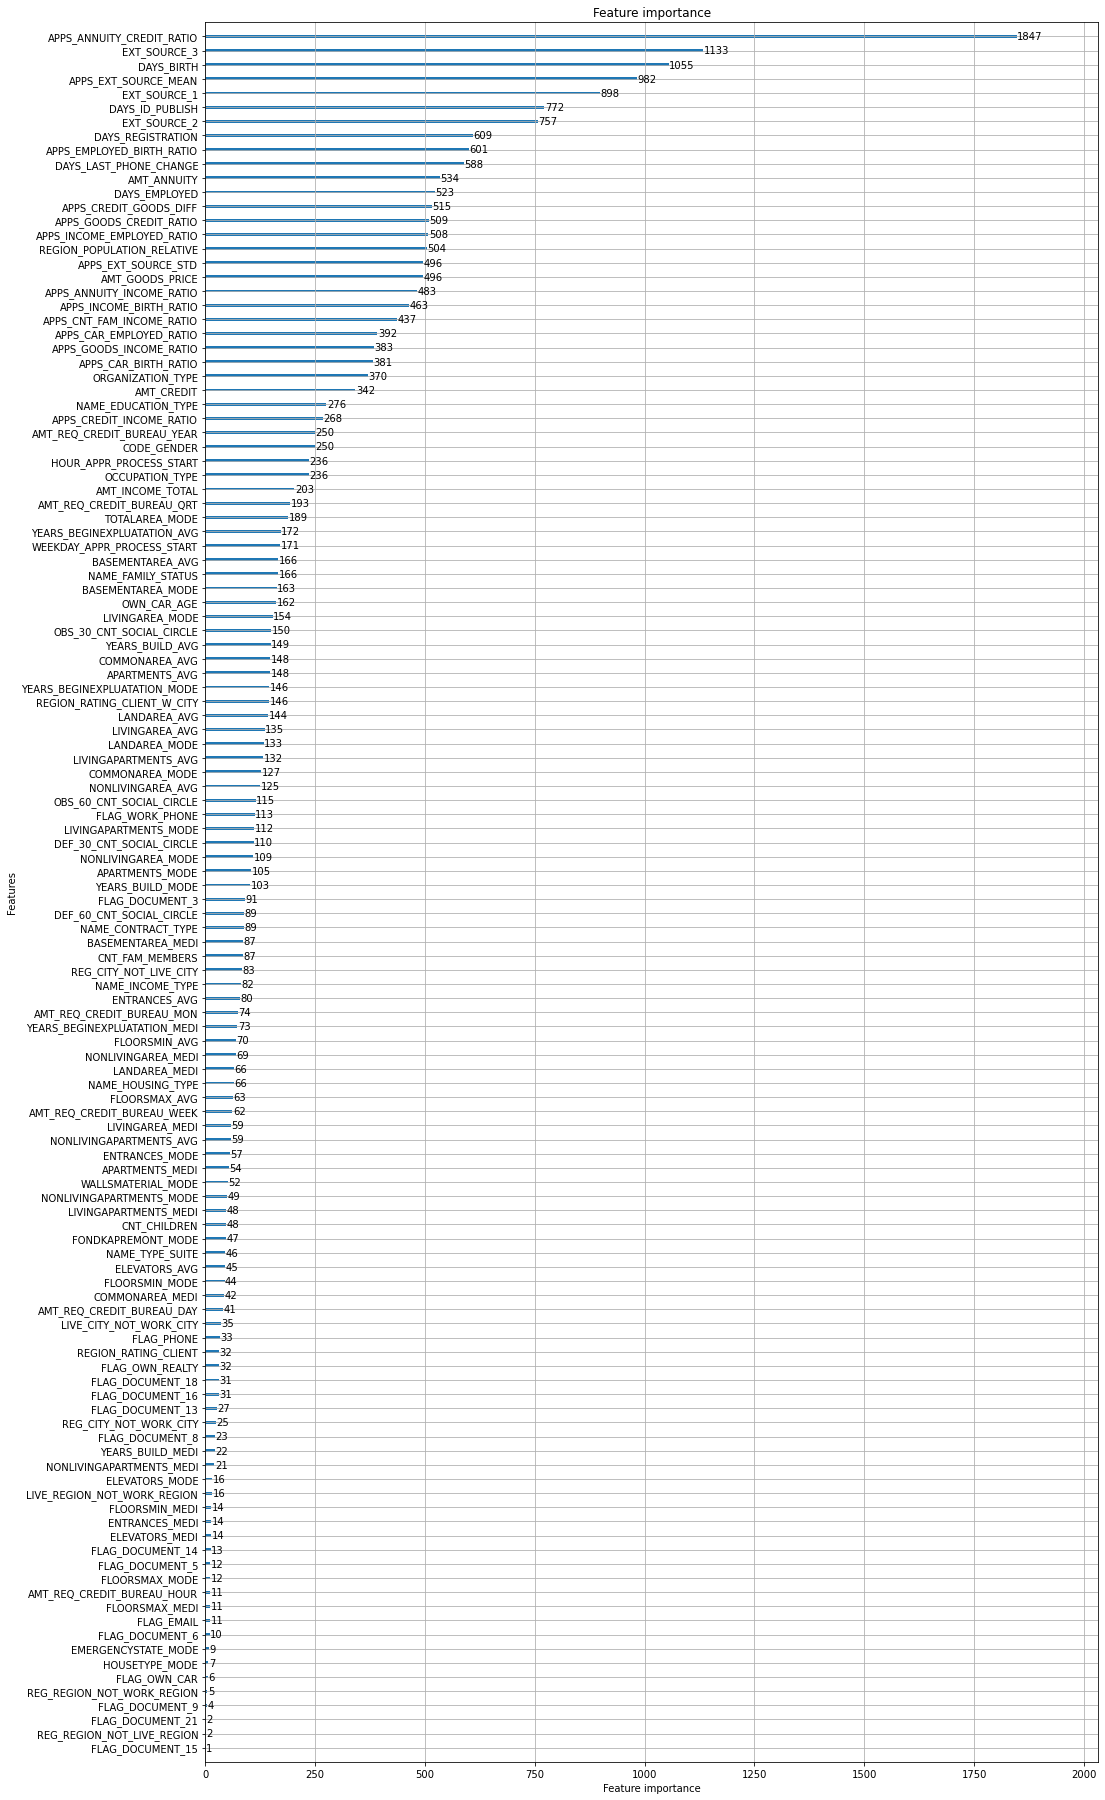

In [36]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

#### 학습된 Classifier를 이용하여 테스트 데이터 예측하고 결과를 Kaggle로 Submit 수행. 

In [37]:
preds = clf.predict_proba(apps_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]

In [38]:
app_test['TARGET'] = preds
app_test[['SK_ID_CURR', 'TARGET']].to_csv('apps_baseline_02.csv', index=False)

#### application 데이터 세트 feature engineering을 함수화

In [39]:
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
      
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
       
    return apps

    